# Monte Carlo: Lecture 6 Excercise
_Jose Javier Fernández González_

Variational Monte Carlo simulation of a harmonic oscillator

## Model

Taking the dimensionless Hamiltonian:

$$
\hat{H} = -\frac{1}{2} \frac{\delta ^2}{\delta x^2} + \frac{ x ^2}{2}
$$

and the Trial Function:

$$
\psi _T (x ; \alpha, \beta) = \exp{(-\alpha |x|^\beta)}
$$

where $\alpha > 0$ and $\beta > 1$ are variational parameters.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Local Energy
def local_energy_estimators(x, alpha, beta, eps=1e-12):
    ax = np.abs(x)

    # potential
    V = 0.5 * x * x

    # handle ax ~ 0 safely (prevent 0)
    ax_safe = max(ax, eps)

    # (f'/f)^2 
    fp_over_f_sq = (alpha * beta * (ax_safe ** (beta - 1.0)))**2

    # f''/f 
    fpp_over_f = (-alpha * beta * (beta - 1.0) * (ax_safe ** (beta - 2.0))) + fp_over_f_sq

    # kinetic estimators
    K1 = -0.5 * fpp_over_f
    K2 =  0.5 * fp_over_f_sq

    # Total energies
    E1 = V + K1
    E2 = V + K2
    return E1, E2, V, K1, K2

## Simulation

In [13]:
# Helper functions

def gen_intial_config():
    return np.random.randn()

def move_points(x, delta=1.0):
    return x + (2*np.random.random() - 1) * delta

def log_psi(x, alpha, beta):
    """log psi_T(x; alpha,beta) = -alpha |x|^beta"""
    return -alpha * (np.abs(x) ** beta)

def log_prob(x, alpha, beta):
    """log p(x) where p=|psi|^2 -> log p = 2 log psi"""
    return 2.0 * log_psi(x, alpha, beta)


# Metropolis
def metropolis_step(x_old, x_new, alpha, beta):
    """
    Metropolis accept/reject using p(x)=|psi|^2
    Accept with prob min(1, exp(logp_new - logp_old)).
    """
    logw = log_prob(x_new, alpha, beta) - log_prob(x_old, alpha, beta)
    if logw >= 0.0:
        return x_new, 1
    else:
        if np.random.random() < np.exp(logw):
            return x_new, 1
        return x_old, 0


In [14]:

# Main simulation
def run_sim(alpha, beta, num_steps=200_000, delta=1.0,
            burn_in=None, sample_every=1,
            density_bins=200, density_xmax=4.0):

    if burn_in is None:
        burn_in = num_steps // 4

    x = gen_intial_config()
    accepted = 0

    # accumulators (post burn-in)
    E1_list = []
    E2_list = []
    V_list  = []
    K1_list = []
    K2_list = []

    # density histogram
    edges = np.linspace(-density_xmax, density_xmax, density_bins + 1)
    hist = np.zeros(density_bins, dtype=float)
    density_samples = 0

    # optionally keep a trace (for debugging/plots)
    E1_trace = np.empty(num_steps, dtype=float)

    for step in range(num_steps):
        x_new = move_points(x, delta=delta)
        x, acc = metropolis_step(x, x_new, alpha, beta)
        accepted += acc

        E1, E2, V, K1, K2 = local_energy_estimators(x, alpha, beta)
        E1_trace[step] = E1

        if step >= burn_in and (step % sample_every == 0):
            E1_list.append(E1)
            E2_list.append(E2)
            V_list.append(V)
            K1_list.append(K1)
            K2_list.append(K2)

            # density
            if -density_xmax <= x < density_xmax:
                b = int((x - (-density_xmax)) / (2*density_xmax) * density_bins)
                if 0 <= b < density_bins:
                    hist[b] += 1
            density_samples += 1

    acc_rate = accepted / num_steps

    # convert lists to arrays
    E1_arr = np.asarray(E1_list)
    E2_arr = np.asarray(E2_list)

    def mean_std_sem(a):
        mean = a.mean()
        std  = a.std(ddof=1)
        sem  = std / np.sqrt(len(a))
        return mean, std, sem

    E1_mean, E1_std, E1_sem = mean_std_sem(E1_arr)
    E2_mean, E2_std, E2_sem = mean_std_sem(E2_arr)

    stats = {
        "alpha": alpha, "beta": beta,
        "num_steps": num_steps, "burn_in": burn_in,
        "delta": delta, "acc_rate": acc_rate,
        "E1_mean": E1_mean, "E1_std": E1_std, "E1_sem": E1_sem,
        "E2_mean": E2_mean, "E2_std": E2_std, "E2_sem": E2_sem,
        "n_meas": len(E1_arr),
    }

    # density profile normalize to integrate to 1
    centers = 0.5 * (edges[:-1] + edges[1:])
    dx = edges[1] - edges[0]
    rho = hist / (density_samples * dx) if density_samples > 0 else np.zeros_like(centers)

    energy_traces = {"E1_trace": E1_trace}

    return x, energy_traces, acc_rate, stats, (centers, rho)


# Scan beta, find optimum, and plot requested results
def scan_beta(alpha, betas, num_steps=200_000, delta=1.0, **kwargs):
    rows = []
    density_best = None
    best_stats = None
    best_energy = np.inf

    for beta in betas:
        _, _, _, stats, density = run_sim(alpha, beta, num_steps=num_steps, delta=delta, **kwargs)
        rows.append(stats)

        if stats["E1_mean"] < best_energy:
            best_energy = stats["E1_mean"]
            best_stats = stats
            density_best = density

    return rows, best_stats, density_best

## Simulation Results
### Energy Dependance

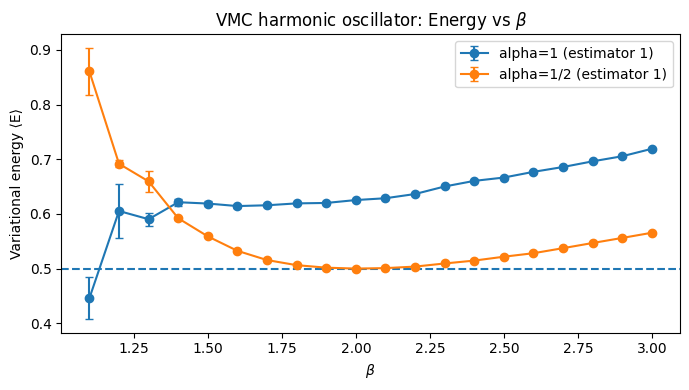

In [20]:
# Fix alpha = 1 and alpha = 1/2, scan beta and plot E(beta)
betas = np.linspace(1.1, 3.0, 20)   # beta > 1 required
num_steps = 500_000
delta = 1.0

rows_a1, best_a1, dens_a1 = scan_beta(alpha=1.0, betas=betas, num_steps=num_steps, delta=delta, sample_every=2)
rows_a05, best_a05, dens_a05 = scan_beta(alpha=0.5, betas=betas, num_steps=num_steps, delta=delta, sample_every=2)

def rows_to_arrays(rows):
    beta = np.array([r["beta"] for r in rows])
    E1   = np.array([r["E1_mean"] for r in rows])
    E1e  = np.array([r["E1_sem"] for r in rows])
    E2   = np.array([r["E2_mean"] for r in rows])
    E2e  = np.array([r["E2_sem"] for r in rows])
    acc  = np.array([r["acc_rate"] for r in rows])
    return beta, E1, E1e, E2, E2e, acc

b1, E1_1, E1e_1, E2_1, E2e_1, acc1 = rows_to_arrays(rows_a1)
b2, E1_05, E1e_05, E2_05, E2e_05, acc05 = rows_to_arrays(rows_a05)

# Plot E(beta) using estimator 1
plt.figure(figsize=(7,4))
plt.errorbar(b1, E1_1, yerr=E1e_1, fmt='o-', capsize=3, label=r'alpha=1 (estimator 1)')
plt.errorbar(b2, E1_05, yerr=E1e_05, fmt='o-', capsize=3, label=r'alpha=1/2 (estimator 1)')
plt.axhline(0.5, linestyle="--")  # exact E0 = 1/2 in these units
plt.xlabel(r'$\beta$')
plt.ylabel(r'Variational energy ⟨E⟩')
plt.title(r"VMC harmonic oscillator: Energy vs $\beta$")
plt.legend()
plt.tight_layout()
plt.show()

### Optimal $\beta$ for minimal energy

========== BEST VARIATIONAL RESULT ==========
alpha = 1.0, beta* = 1.100000
steps = 500000, burn_in = 125000, delta = 1.0
acceptance = 0.627
Using estimator 1 (Laplacian/direct):
  E = 0.445863 ± 0.038361
Using estimator 2 (drift):
  E = 0.690499 ± 0.001158
Exact ground state energy: E0 = 0.5
========== BEST VARIATIONAL RESULT ==========
alpha = 0.5, beta* = 2.000000
steps = 500000, burn_in = 125000, delta = 1.0
acceptance = 0.729
Using estimator 1 (Laplacian/direct):
  E = 0.500000 ± 0.000000
Using estimator 2 (drift):
  E = 0.499186 ± 0.001622
Exact ground state energy: E0 = 0.5


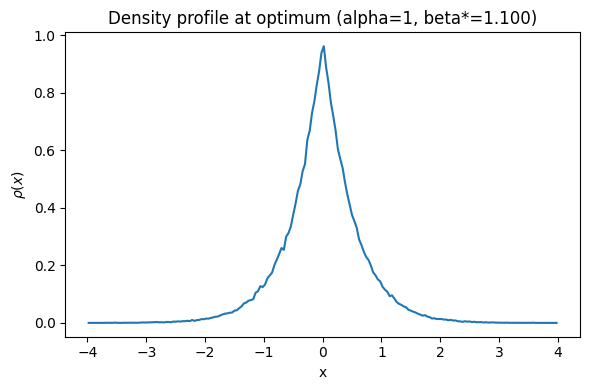

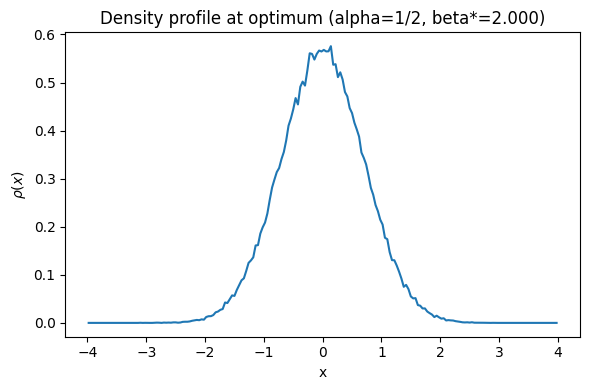

In [21]:

# Report optimal beta and best energies using both kinetic estimators
def print_best(best):
    print("========== BEST VARIATIONAL RESULT ==========")
    print(f"alpha = {best['alpha']}, beta* = {best['beta']:.6f}")
    print(f"steps = {best['num_steps']}, burn_in = {best['burn_in']}, delta = {best['delta']}")
    print(f"acceptance = {best['acc_rate']:.3f}")
    print("Using estimator 1 (Laplacian/direct):")
    print(f"  E = {best['E1_mean']:.6f} ± {best['E1_sem']:.6f}")
    print("Using estimator 2 (drift):")
    print(f"  E = {best['E2_mean']:.6f} ± {best['E2_sem']:.6f}")
    print("Exact ground state energy: E0 = 0.5")
    print("============================================")

print_best(best_a1)
print_best(best_a05)

# Density profile for optimal parameters
def plot_density(density, title):
    xg, rho = density
    plt.figure(figsize=(6,4))
    plt.plot(xg, rho, linewidth=1.5)
    plt.xlabel("x")
    plt.ylabel(r"$\rho(x)$")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_density(dens_a1,  f"Density profile at optimum (alpha=1, beta*={best_a1['beta']:.3f})")
plot_density(dens_a05, f"Density profile at optimum (alpha=1/2, beta*={best_a05['beta']:.3f})")

### Conclusion
When the trial wavefunction contains the exact solution (alpha=1/2, beta=2), the local energy becomes constant and equal to the exact ground state energy. So, the first kinetic energy estimator shows zero variance and reproduces the exact energy.

The second estimator, shows finite fluctuations even for the exact wavefunction, even though its average energy is the right one. Therefore, its variance is larger.

So, when the exact wavefunction is used, different estimators of the kinetic energy can have very different variances, and the Laplacian estimator is more efficient because it achieves zero variance in the exact case.